<a href="https://colab.research.google.com/github/gabridulol/nn-and-dl/blob/main/pa4_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Gabriel Rodrigues Marques (5097)

# **P4: Recurrent Neural Networks**

### **Introduction**
In this practical project, you will implement a recurrent neural network (RNN) in PyTorch to generate Pokemon names using a character-level language model. First, you will create a class to load the dataset. Second, you will build a traditional RNN. Third, you will train this network using mini-batch gradient descent. Finally, you will use the trained model to generate new Pokemon names.

### **Objective**

The main objective of this project is to practice implementing RNNs in PyTorch, including dataset loading, implementing custom layers, training with gradient descent, and generating with language models.

### **Instructions**

After each cell of this type, there is a test cell followed by expected results, so you can check if your solution is correct. Your results might be slightly diferent from the expected results and still be correct.

### **Part 0: Import libraries**

As in the previous programming, you will import the `torch` library and other  auxiliary libraries.

In [1]:
import torch
import sys
import random
import string
import time


from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

### **Part 1: Loading and preprocessing the dataset**

In this first part, you will download the dataset as a txt file (pokemons.txt), which contains names of 890 Pokemon created from the first to the eighth generation of the series. Each name is separated by a \n character.

In [2]:
!wget -O 'data/pokemons.txt' 'https://raw.githubusercontent.com/gabridulol/nn-and-dl/main/data/pokemons.txt'

--2025-10-27 20:49:57--  https://raw.githubusercontent.com/gabridulol/nn-and-dl/main/data/pokemons.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7602 (7.4K) [text/plain]
Saving to: ‘data/pokemons.txt’

data/pokemons.txt   100%[===================>]   7.42K  --.-KB/s    in 0s      

2025-10-27 20:49:57 (105 MB/s) - ‘data/pokemons.txt’ saved [7602/7602]



#### **1.1 Download data and create vocabulary**

Read the 'pokemons.txt' file to load all pokemon names from Generation 1 through Generation 8 in a list and produce the train/test sets randomly using a 80/20 split. Moreover, create a vocabulary (list) with all the characters in the text file sorted alphabetically. Make sure to include three extra control characters in your vocabulary: '[' (SOS), ']' (EOS), '@' (padding)

In [3]:
random.seed(42)

# Read names
file_path = "data/pokemons.txt"
with open(file_path, "r", encoding="utf-8") as file:
    raw_text = file.read().splitlines()

# Shuffle names
random.shuffle(raw_text)

# Randomly split the dataset using a 80/20 split
split_idx = int(0.8 * len(raw_text))
train_text = raw_text[:split_idx]
test_text = raw_text[split_idx:]

# Create vocabulary from raw_text and include special tokens
vocab = sorted(list(set("".join(raw_text) + "^$@\n")))

print("First 5 training examples:", train_text[:5])
print("First 5 test examples:", test_text[:5])
print("First 10 characters of vocabulary:", vocab[:10])
print("Vocabulary size", len(vocab))

First 5 training examples: ['Shellos', 'Haunter', 'Ninjask', 'Snover', 'Araquanid']
First 5 test examples: ['Pansear', 'Dracovish', 'Charmander', 'Zeraora', 'Furret']
First 10 characters of vocabulary: ['\n', ' ', '$', "'", '-', '.', '2', ':', '@', 'A']
Vocabulary size 65


**Expected result**:

<table style="width:50%">
  <tr>
    <td> First 5 training examples </td>
    <td>['Shellos', 'Haunter', 'Ninjask', 'Snover', 'Araquanid']</td>
  </tr>
  <tr>
    <td> First 5 test examples </td>
    <td>['Pansear', 'Dracovish', 'Charmander', 'Zeraora', 'Furret']</td>
  </tr>
  <tr>
    <td> First 10 characters of vocabulary </td>
    <td>['\n', ' ', "'", '-', '.', '2', ':', '@', 'A', 'B']</td>
  </tr>
    <tr>
    <td> Vocabulary Size </td>
    <td> 65</td>
  </tr>
</table>

#### **1.2 Create a Dataset class to store the dataset**

PyTorch provides the [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class for loading datasets from files. To create a custom dataset, you need to extend the Dataset class and implement three functions: `__init__`, `__len__`, and `__getitem__`. In this step, you will implement these three functions and some auxiliary ones to build a dataset for your Pokemon names language model.

- `__init__`:
  Initialize the dataset by creating attributes to store the names and the vocab. Add SOS/EOS tokens to each name before storing them. Morever, create mappings between characters and indices and vice versa. It is also useful to compute and store the max len of a word in the dataset.

- `one_hot_encode(ix)`:
  Create a one-hot encoded tensor for a given index.

- `encode(seq_ch)`:
  Convert a sequence of characters into a tensor of one-hot vectors.

- `decode(seq_ix)`:
  Convert a sequence of indices back into a string of characters.

- `__len__`:
  Return the total number of sequences in the dataset.

- `__getitem__(index)`:
  Process a single Pokemon name by padding (with @) to match the longest sequence length, and returning input-output tensor pairs. Use `torch.tensor()` to convert the output sequence to a tensor.

Remember that for language modeling, your input sequences (`x`) should be shifted by one character relative to your target sequences (`y`), allowing the model to predict the next character in the sequence.

In [4]:
class INF721Dataset(Dataset):
    def __init__(self, names, vocab):
        """
        Initialize the dataset by creating mappings and preparing the data.

        Args:
            names (list[str]): List of Pokémon names.
            vocab (list[str]): List of unique characters.
        """

        # Special tokens
        self.SOS = "^"   # Start of sequence
        self.EOS = "$"   # End of sequence
        self.PAD = "@"   # Padding
        self.NL = "\n"   # New line

        # Add special tokens if not already in vocab
        for token in [self.SOS, self.EOS, self.PAD, self.NL]:
            if token not in vocab:
                vocab.append(token)

        # Sort vocab for consistency
        self.vocab = sorted(vocab)

        # Create char <-> index mappings
        self.ch2ix = {ch: ix for ix, ch in enumerate(self.vocab)}
        self.ix2ch = {ix: ch for ch, ix in self.ch2ix.items()}

        # Add SOS and EOS tokens to each name
        self.sequences = [self.SOS + name + self.EOS for name in names]

        # Store max sequence length
        self.max_len = max(len(seq) for seq in self.sequences)


    def one_hot_encode(self, ix):
      """
      Create a one-hot encoded tensor for a given index.

      Args:
          ix (int): The index to encode.

      Returns:
          torch.Tensor: A one-hot encoded tensor of shape (vocab_size).
      """
      
      vec = torch.zeros(len(self.vocab))
      vec[ix] = 1.0
      return vec

    def encode(self, seq_ch):
      """
      Convert a sequence of characters into a tensor of one-hot vectors.

      Args:
          seq_ch (str): A string representing the sequence of characters to encode.

      Returns:
          torch.Tensor: A tensor of one-hot vectors representing the input sequence.
      """
      
      seq_ix = [self.ch2ix[ch] for ch in seq_ch]
      one_hot_seq = torch.stack([self.one_hot_encode(ix) for ix in seq_ix])
      return one_hot_seq

    def decode(self, seq_ix):
      """
      Convert a sequence of indices back into a string of characters.

      Args:
          seq_ix (list): A list of indices representing the characters in the sequence.

      Returns:
          str: The decoded string of characters.
      """

      decoded_chars = [self.ix2ch[ix] for ix in seq_ix]
      return "".join(decoded_chars)

    def __len__(self):
      """
      Get the total number of sequences in the dataset.

      Returns:
          int: The total number of sequences in the dataset.
      """

      return len(self.sequences)

    def __getitem__(self, index):
      """
      Get a single sample from the dataset.

      Args:
          index (int): Index of the sample to retrieve.

      Returns:
          tuple: A tuple containing the input tensor x and the target tensor y.
      """

      seq = self.sequences[index]

      # Pad to max length
      seq = seq + self.PAD * (self.max_len - len(seq))

      # Convert chars to indices
      seq_ix = [self.ch2ix[ch] for ch in seq]

      # Shift sequences: x = input, y = target
      x_ix = seq_ix[:-1]
      y_ix = seq_ix[1:]

      # Encode x as one-hot, y as indices
      x = self.encode([self.ix2ch[ix] for ix in x_ix])
      y = torch.tensor(y_ix, dtype=torch.long)

      return x, y

    @property
    def vocab_size(self):
      """
      Get the size of the vocabulary.

      Returns:
          int: The size of the vocabulary.
      """

      return len(self.vocab)

In [5]:
train_dataset = INF721Dataset(train_text, vocab)
test_dataset = INF721Dataset(test_text, vocab)

print("Train vocabulary size:", train_dataset.vocab_size)
print("Test vocabulary size:", test_dataset.vocab_size)

print("Train max sequence length:", train_dataset.max_len)
print("Test max sequence length:", test_dataset.max_len)

print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

Train vocabulary size: 65
Test vocabulary size: 65
Train max sequence length: 14
Test max sequence length: 13
Train dataset size: 712
Test dataset size: 178


**Expected result**:

<table style="width:50%">
  <tr>
    <td> Train vocabulary size </td>
    <td>65</td>
  </tr>
  <tr>
    <td> Test vocabulary size </td>
    <td>65</td>
  </tr>
  <tr>
    <td> Train max sequence length </td>
    <td>14</td>
  </tr>
  <tr>
    <td> Test max sequence length </td>
    <td>13</td>
  </tr>
  <tr>
    <td> Train dataset size </td>
    <td>712</td>
  </tr>
    <tr>
    <td> Test dataset size </td>
    <td>178</td>
  </tr>
</table>

#### **1.3 Visualization of examples**

If you loaded the data correctly, you can use the code below to visualize examples from the dataset.

In [6]:
x = train_dataset.sequences[0]
x_encoded, y = train_dataset[0]
print("x0", x)
print("x0_encoded size", x_encoded.size())
print("y", y)

x0 ^Shellos$
x0_encoded size torch.Size([13, 65])
y tensor([27, 43, 40, 47, 47, 50, 54,  2,  8,  8,  8,  8,  8])


**Expected result**:

<table style="width:50%">
  <tr>
    <td>x0</td>
    <td>[Shellos]</td>
  </tr>
  <tr>
    <td>x0 encoded size</td>
    <td>[13, 65]</td>
  </tr>
  <tr>
    <td> y </td>
    <td>[26, 43, 40, 47, 47, 50, 54, 35,  7,  7,  7,  7,  7]</td>
  </tr>
</table>

#### **1.4 Create a DataLoader to iterate through examples**

 Create a `train_loader` and a `test_loader` using PyTorch's [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training and test set. Configure both of them with:
- batch_size = 32
- drop_last = True (to remove the last potentially incomplete minibatch)

Make sure to set shuffle parameter to True in your training data loader. You don't need to shuffle the test data loader.


In [7]:
# Create training data loader
train_dataset = INF721Dataset(train_text, vocab)
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=False
)

# Create test data loader
test_dataset = INF721Dataset(test_text, vocab)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False
)

In [8]:
torch.manual_seed(1)

# Assuming the variable train_loader have been defined in the previous cell.
train_x_batch, train_y_batch = next(iter(train_loader))
test_x_batch, test_y_batch = next(iter(test_loader))

print("A single training batch size: ", train_x_batch.size())
print("A single test batch size: ", test_x_batch.size())

print("Train Sanity check: ", train_x_batch[0][1])
print("Test Sanity check: ", test_x_batch[0][1])

A single training batch size:  torch.Size([32, 13, 65])
A single test batch size:  torch.Size([32, 12, 65])
Train Sanity check:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Test Sanity check:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


**Expected result**:

<table style="width:50%">
  <tr>
    <td> Single training batch size </td>
    <td>[32, 13, 65]</td>
  </tr>
  <td> Single test batch size </td>
    <td>[32, 12, 65]</td>
  </tr>
  <tr>
    <td> Train Sanity check </td>
    <td>[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
    </td>
  </tr>
    <tr>
    <td> Test Sanity check </td>
    <td>[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
    </td>
  </tr>
</table>

## **Part 2: Recurrent Neural Network**

Now that you have a dataset ready for training, it's time to create your RNN.

#### **2.1 Recurrent Hidden Layer**

The first step to create your RNN is to implement a class that extends `torch.nn.Module` with `__init__` to initialize the RNN weights and `forward(x)` for input propagation.

- Weight initialization (`__init__`):
  Use [`torch.nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html) to initialize the RNN weights:
  - `self.Wx`: input weights
  - `self.Wh`: hidden state weights
  - `self.b`: bias
  
  Initialize weights with small random values (`torch.randn * 0.01`) and bias with zeros (`torch.zeros`).

- Forward propagation (`forward(x)`):
  Implement the RNN forward pass (for the hidden layear only) following this equation:

  \begin{align}
    h^{<t>} &= tanh(W_{h} h^{<t-1>} + W_{x}x^{<t>} + b) \\
  \end{align}
  where:
  - x_t is the input at time t
  - h_t is the hidden state at time t
  - Wx, Wh, and b are the learnable parameters

  Remember to:
  1. Handle the initial hidden state case
  2. Process input sequence from left to right
  3. Use `torch.cat` to combine hidden states
  4. Use `permute` to arrange the output tensor in the format (batch_size, seq_len, hidden_size)

In [9]:
class INF721RNNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        """
        Initialize the RNN layer.

        Args:
            input_size (int): The number of expected features in the input x.
            hidden_size (int): The number of features in the hidden state h.
        """
        
        super(INF721RNNLayer, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        # Initialize weights and bias
        self.Wx = torch.nn.Parameter(torch.randn(input_size, hidden_size) * 0.01)
        self.Wh = torch.nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.01)
        self.b = torch.nn.Parameter(torch.zeros(hidden_size))

    def forward(self, x, h_prev):
        """
        Forward pass of the entire RNN.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, input_size).
            h_prev (torch.Tensor): Initial hidden state tensor of shape (batch_size, hidden_size).

        Returns:
            outputs (torch.Tensor): Sequence
            h_t: The final hidden state after processing the entire sequence x.
        """
        
        batch_size, seq_len, _ = x.shape

        # Initialize hidden state if not provided
        if h_prev is None:
            h_prev = torch.zeros(batch_size, self.hidden_size, device=x.device)

        # To store hidden states for all time steps
        hidden_states = []

        # Iterate over time steps
        for t in range(seq_len):
            x_t = x[:, t, :]  # (batch_size, input_size)
            h_t = torch.tanh(x_t @ self.Wx + h_prev @ self.Wh + self.b)
            hidden_states.append(h_t)
            h_prev = h_t

        # Concatenate hidden states over time and permute dimensions
        outputs = torch.stack(hidden_states, dim=1)  # (batch_size, seq_len, hidden_size)

        return outputs, h_t

In [10]:
torch.manual_seed(1)

rnn_layer = INF721RNNLayer(input_size=train_dataset.vocab_size, hidden_size=10)
x, y = train_dataset[0]

with torch.no_grad():
  outputs, hidden = rnn_layer(x.unsqueeze(0), None)

print("Outputs size:", outputs.size())
print("Last hidden state:", hidden)

Outputs size: torch.Size([1, 13, 10])
Last hidden state: tensor([[-0.0048,  0.0011, -0.0063,  0.0073, -0.0143, -0.0052,  0.0017, -0.0019,
          0.0026, -0.0050]])


**Expected result**:

<table style="width:50%">
  <tr>
    <td> **Outputs size** </td>
    <td>[1, 13, 10]</td>
  </tr>
  <tr>
    <td> **Last hidden state** </td>
    <td>[[[-0.0159, -0.0070, -0.0190, -0.0087, 0.0080, -0.0072, -0.0066,
          -0.0208, -0.0029, 0.0080]]]</td>
  </tr>
</table>

#### **2.2 Language Model**

Use your recurrent layer to define your language model. Extend `torch.nn.Module` to create a language model that can predict the next character in a sequence.

Your model should contain:
- A recurrent layer (from your previous implementation)
- A fully connected layer using [`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

The architecture should:
- Take one-hot encoded characters as input (size of vocabulary)
- Process them through the RNN layer (produces hidden states)
- Pass the hidden states through a linear layer to predict the next character
- Return both the predictions and the final hidden state

Remember that the linear layer should process the RNN output for each timestep to make character predictions.

Parameters:
- Input size: vocab_size
- Hidden size: as specified by hidden_size parameter
- Output size: vocab_size (to predict probabilities for each possible character)

In [11]:
class INF721RNNLanguageModel(torch.nn.Module):
    def __init__(self, vocab_size, hidden_size):
        """
        Simple RNN-based language model.

        Args:
            vocab_size (int): Size of the character vocabulary.
            hidden_size (int): Number of features in the hidden state.
        """

        super(INF721RNNLanguageModel, self).__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        # Recurrent layer
        self.rnn = INF721RNNLayer(input_size=vocab_size, hidden_size=hidden_size)

        # Fully connected layer
        self.fc = torch.nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        """
        Forward pass for the language model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, vocab_size).
            hidden (torch.Tensor): Initial hidden state (optional).

        Returns:
            logits (torch.Tensor): Predictions for each character
                                   shape (batch_size, seq_len, vocab_size)
            h_t (torch.Tensor): Final hidden state from the RNN.
        """
        
        # Pass input through the recurrent layer
        rnn_out, h_t = self.rnn(x, hidden)  # (batch, seq_len, hidden_size)

        # Pass RNN outputs through linear layer to get logits
        logits = self.fc(rnn_out)  # (batch, seq_len, vocab_size)

        return logits, h_t

In [12]:
torch.manual_seed(1)

x, y = train_dataset[0]

language_model = INF721RNNLanguageModel(vocab_size=train_dataset.vocab_size, hidden_size=10)
with torch.no_grad():
  outputs, hidden = language_model(x.unsqueeze(0), None)

print("Output size:", outputs.size())
print("Hidden state:", hidden)

Output size: torch.Size([1, 13, 65])
Hidden state: tensor([[-0.0048,  0.0011, -0.0063,  0.0073, -0.0143, -0.0052,  0.0017, -0.0019,
          0.0026, -0.0050]])


**Expected result**:

<table style="width:50%">
  <tr>
    <td> Output size </td>
    <td>[1, 13, 65]</td>
  </tr>
  <tr>
    <td> Hidden state </td>
    <td>[[[-0.0159, -0.0070, -0.0190, -0.0087, 0.0080, -0.0072, -0.0066,
          -0.0208, -0.0029, 0.0080]]]</td>
  </tr>
</table>

## **Part 3: Training with Mini-batch Gradient Descent**

In the third step, you will write the training loop for your Pokemon names language model.

#### **3.1 Calculate loss on test set**

Before writting the training loop, you will need to implement a function to compute the loss on the test set, so you can store the test error over the training epochs. To compute the loss, run the forward pass for each mini-batch of your test set and sum the losses of each mini-batch. Return the average loss by dividing this sum by the number of mini-batches in the test set.

In [13]:
def test(model, test_loader):
  """
  Evaluate a given model on a dataset stored in dataloader

  Arguments:
  - model (torch.nn.Module): A language model to evaluate.
  - test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
  """

  model.eval()  # set model to evaluation mode
  total_loss = 0.0
  total_batches = 0

  criterion = torch.nn.CrossEntropyLoss()

  with torch.no_grad():
      for x_batch, y_batch in test_loader:
          # Move data to same device as model
          x_batch = x_batch.to(next(model.parameters()).device)
          y_batch = y_batch.to(next(model.parameters()).device)

          # Forward pass
          logits, _ = model(x_batch)

          # Reshape tensors for CrossEntropyLoss
          # logits: (batch, seq_len, vocab_size) -> (batch * seq_len, vocab_size)
          # targets: (batch, seq_len) -> (batch * seq_len)
          loss = criterion(logits.view(-1, model.vocab_size), y_batch.view(-1))

          total_loss += loss.item()
          total_batches += 1

  avg_loss = total_loss / total_batches if total_batches > 0 else float('inf')

  return avg_loss

In [14]:
torch.manual_seed(1)

language_model = INF721RNNLanguageModel(vocab_size=train_dataset.vocab_size, hidden_size=10)

loss = test(language_model, test_loader)
print("Test loss:", loss)

Test loss: 4.084333896636963


**Expected result**:

<table style="width:50%">
  <tr>
    <td> Test Loss </td>
    <td>4.233950805664063</td>
  </tr>
</table>

#### **3.2 Training loop**

The training loop is similar to the previous project, with two key differences:

1. Initialize the hidden vector as `None` at the start of each mini-batch (since names are independent sequences)
2. Add gradient clipping using [`torch.nn.utils.clip_grad_norm_`](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) with a maximum norm of 5 before the optimizer step

Training specifications:
- Number of epochs: 100
- Print loss every 10 epochs
- Use provided dataloader for mini-batches
- Reset hidden state for each mini-batch
- Clip gradients before weight updates

Remember to:
- Define your loss function and optimizer
- Track and store training losses
- Apply gradient clipping before optimizer.step()

In [15]:
def optimize(model, train_loader, test_loader, vocab_size, learning_rate=0.001, num_epochs=100, outpath='data/inf721net.pth'):
  """
  Train a given model on a dataset stored in dataloader

  Arguments:
  - model (torch.nn.Module): A language model to train.
  - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
  - test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
  - vocab_size (int): Size of the vocabulary.
  - learning_rate (float): Learning rate for the optimizer.
  - num_epochs (int): Number of training epochs.
  - outpath (str): Path to save the trained model.
  """
  
  # Define loss function and optimizer
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Lists to store the average training and testing errors
  train_losses = []
  test_losses = []

  for epoch in range(num_epochs):
      model.train()
      total_train_loss = 0.0
      total_batches = 0

      for x_batch, y_batch in train_loader:
          # Forward pass
          logits, _ = model(x_batch)

          # Compute loss
          loss = criterion(logits.view(-1, vocab_size), y_batch.view(-1))

          # Backpropagation
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          total_train_loss += loss.item()
          total_batches += 1

      # Average train loss
      avg_train_loss = total_train_loss / total_batches
      train_losses.append(avg_train_loss)

      # Evaluate on test data
      test_loss = test(model, test_loader)
      test_losses.append(test_loss)
      
      print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss} | Test Loss: {test_loss}")

  # Save the trained model as a file
  torch.save(model.state_dict(), outpath)
  print(f"✅ Model saved to {outpath}")

  return train_losses, test_losses

In [16]:
torch.manual_seed(1)

# Create the model
model = INF721RNNLanguageModel(train_dataset.vocab_size, hidden_size=50)

# Train the model
train_losses, test_losses = optimize(model, train_loader, test_loader, train_dataset.vocab_size, num_epochs=100)

Epoch [1/100] | Train Loss: 4.036365436471027 | Test Loss: 3.7003762324651084
Epoch [2/100] | Train Loss: 2.8664379741834556 | Test Loss: 2.8760578632354736
Epoch [3/100] | Train Loss: 2.5909182818039604 | Test Loss: 2.7630234956741333
Epoch [4/100] | Train Loss: 2.5318762530451235 | Test Loss: 2.713816205660502
Epoch [5/100] | Train Loss: 2.4684248592542564 | Test Loss: 2.6686302423477173
Epoch [6/100] | Train Loss: 2.411473212034806 | Test Loss: 2.6050061782201133
Epoch [7/100] | Train Loss: 2.3480029728101646 | Test Loss: 2.5257423321406045
Epoch [8/100] | Train Loss: 2.264066862023395 | Test Loss: 2.458672285079956
Epoch [9/100] | Train Loss: 2.2078741426053257 | Test Loss: 2.4111812114715576
Epoch [10/100] | Train Loss: 2.1601615159407905 | Test Loss: 2.3715091546376548
Epoch [11/100] | Train Loss: 2.132415631543035 | Test Loss: 2.352934161822001
Epoch [12/100] | Train Loss: 2.1046776460564653 | Test Loss: 2.3153719902038574
Epoch [13/100] | Train Loss: 2.0655681361322817 | Test L

**Expected result**:
<table>
    <tr>
        <td> Epoch 10/200</td>
        <td> Train Loss: 2.2395649281415073, Test Loss: 2.4271461009979247</td>
    </tr>
    <tr>
         <td> Epoch 20/200</td>
        <td> Train Loss: 1.912691669030623, Test Loss: 2.1236252069473265</td>
    </tr>
    <tr>
        <td> ...</td>
        <td> ... </td>
    </tr>
    <tr>
         <td> Epoch 100/100</td>
        <td> Train Loss: 1.5390102646567605, Test Loss: 1.8045806407928466</td>
    </tr>
</table>

#### **3.3 Plot learning curve**

Plot the training and test learning curves using matplotlib.

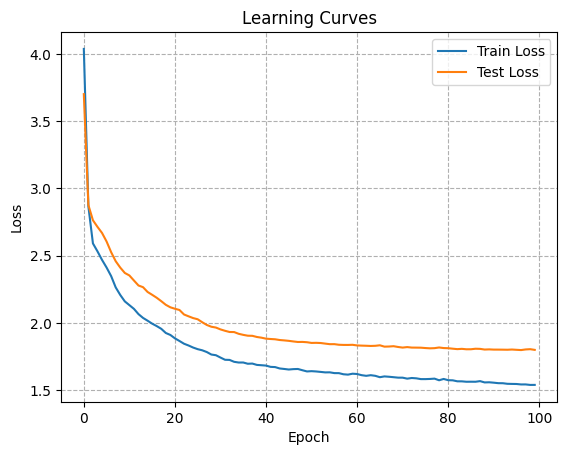

In [17]:
# Plot the training and test learning curves using matplotlib.
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title('Learning Curves')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

**Expected result**

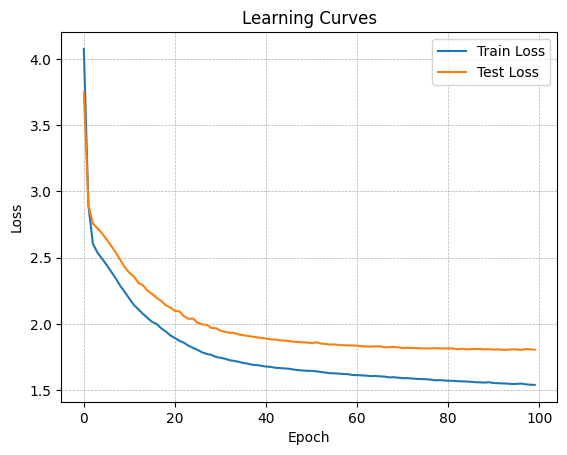

## **Part 4: Sampling from the Language Model**

In the fourth and final part, you will use your trained language model to generate new Pokemon names.

To generate names:

1. Start with a prime string and feed it through the model character by character using the `encode` function from `INF721Dataset` to create one-hot vectors.

2. For character generation:
   - Apply [`torch.nn.functional.softmax`](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html) to the model output to get probabilities
   - Use [`torch.multinomial`](https://pytorch.org/docs/stable/generated/torch.multinomial.html) for sampling the next character index
   - Convert the index back to a character using the `decode` function

3. Generation loop:
   - Continue generating characters until you encounter the end token `"]"`
   - Feed each generated character back as input for the next prediction
   - Collect all generated characters to form the final name

Parameters to use:
- Prime string: starting sequence for generation
- Temperature: controls randomness in generation (if implemented)
- Model should be in evaluation mode during generation

In [18]:
def generate(model, text_dataset, prime="A", max_length=20, temperature=1.0, random_start=True):
	"""
	Generate a pokemon name

  Arguments:
  	- model (torch.nn.Module): A trained language model to sample names from.
		- text_dataset (torch.utils.data.Dataset): A language model dataset to access to encode/decode pokemon names
		- prime (str): A prime sequence to start the generation process.
		- max_length (int): Maximum length of the generated name.
		- temperature (float): Sampling temperature (controls creativity).
    - random_start (bool): If True, randomly chooses an uppercase starting letter.- temperature (float): Sampling temperature.

	Returns:
	- pokemon_name (str): A pokemon generated name.
	"""

	model.eval()
	generated = prime
	hidden = None

	# Optionally pick a random starting letter
	if random_start:
			valid_letters = [ch for ch in text_dataset.vocab if ch.isalpha() and ch.isupper()]
			if valid_letters:
					prime = random.choice(valid_letters)
					generated = prime

	# Feed the prime sequence into the model to set initial hidden state
	for ch in prime:
			if ch not in text_dataset.ch2ix:
					continue
			x = text_dataset.encode(ch).unsqueeze(0)
			with torch.no_grad():
					_, hidden = model(x, hidden)

	next_char = prime[-1] if prime[-1] in text_dataset.ch2ix else text_dataset.SOS

	# Generate characters sequentially
	for _ in range(max_length):
			x = text_dataset.encode(next_char).unsqueeze(0)
			with torch.no_grad():
					logits, hidden = model(x, hidden)

			# Apply temperature for diversity
			probs = torch.nn.functional.softmax(logits[:, -1, :] / temperature, dim=-1).squeeze()
			next_ix = torch.multinomial(probs, 1).item()
			next_char = text_dataset.ix2ch[next_ix]

			# Stop if end or padding token
			if next_char in [text_dataset.EOS, text_dataset.PAD]:
					break

			generated += next_char

	# Clean up unwanted tokens
	generated = (
			generated.replace(text_dataset.SOS, "")
			.replace(text_dataset.EOS, "")
			.replace(text_dataset.PAD, "")
			.strip()
	)

	# Capitalize for better readability
	if len(generated) < 2:
			return None

	return generated.capitalize()


In [33]:
torch.manual_seed(1)

model = INF721RNNLanguageModel(train_dataset.vocab_size, hidden_size=50)
model.load_state_dict(torch.load('data/inf721net.pth'))

n_pokemons = 10

for i in range(n_pokemons):
    p = generate(model, train_dataset)
    print(p)

Mect
Insorpew
Qeipi
Reer
Porans
Ovtws
Clubsh
Tarlishe
Bura
Nastoy


**Expected result**:
<table>
    <tr>
        <td> [Mamperer]</td>
    </tr>
    <tr>
        <td> [Viitindy]</td>
    </tr>
    <tr>
        <td> [Wonavoraro]</td>
    </tr>
    <tr>
        <td> [Dytlecan]</td>
    </tr>
    <tr>
        <td> [Sninourl]</td>
    </tr>
    <tr>
        <td> [Hootol]</td>
    </tr>
    <tr>
        <td> [Santak]</td>
    </tr>     
    <tr>
        <td> [Parory]</td>
    </tr>
    <tr>
        <td> [heix]</td>
    </tr>   
    <tr>
        <td> [Pogoscorm]</td>
    </tr>                    
</table>

Congratulations! Your language model is ready to generate new Pokemon!

## **Part 5: Generate your own Pokemon**

Use the generate function to create a list of Pokemon names. When you find a name you like, use the Bing Image Generator to illustrate your new Pokemon:

https://www.bing.com/create

Tip: use a prompt like "Generate a fake pokemon named [POKEMON_NAME] in the style of the [GENERATION NUMBER] generation."

Expected Result:

Generate a fake pokemon named Heix in the style of the 1st generation.

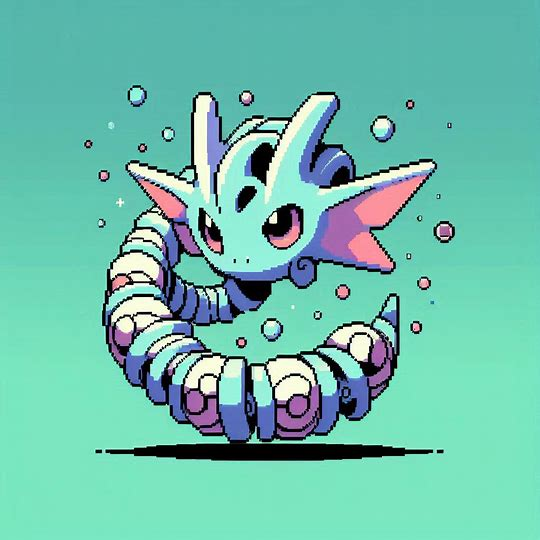

Generate a fake pokemon named Tarlishe in the style of the 9st generation.

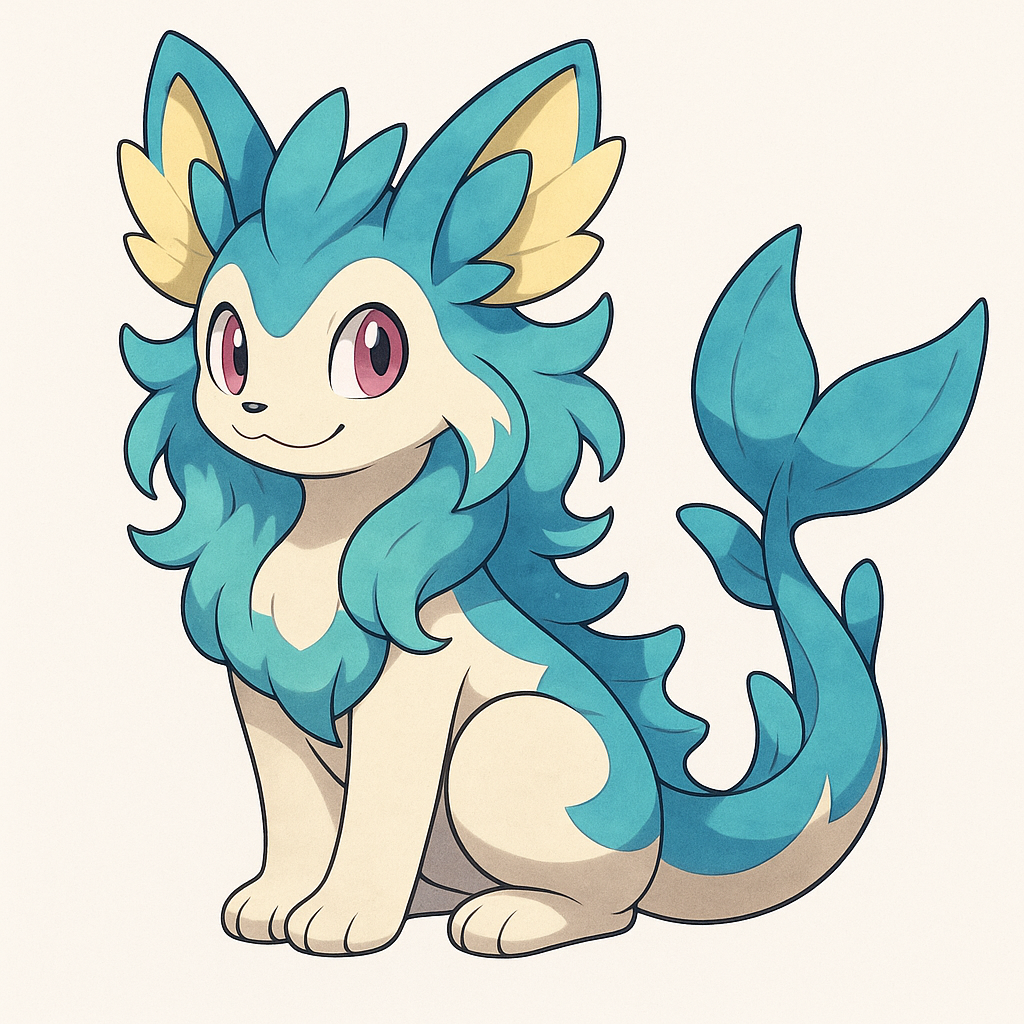

## **Part 6: Challenge (Optional)**

Create an LSTM or a GRU network to build a character-level language model to generate novels like Machado de Assis. You will have access to the training and validation sets, but not to the test set. The model with lower error on the test set will get 1 extra point! You can try any idea we've seen in the course so far to build your model. Report the results with a plot containing the training and validation learning curves, as you did before with the pokemon dataset. Also show the results of some generated novel you were able to produce with your model.

In [20]:
!wget -O 'data/machado_train.txt' 'https://raw.githubusercontent.com/gabridulol/nn-and-dl/main/data/machado_train.txt'
!wget -O 'data/machado_valid.txt' 'https://raw.githubusercontent.com/gabridulol/nn-and-dl/main/data/machado_valid.txt'

--2025-10-27 20:50:10--  https://raw.githubusercontent.com/gabridulol/nn-and-dl/main/data/machado_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1819584 (1.7M) [text/plain]
Saving to: ‘data/machado_train.txt’

data/machado_train. 100%[===================>]   1.73M  --.-KB/s    in 0.06s   

2025-10-27 20:50:12 (27.2 MB/s) - ‘data/machado_train.txt’ saved [1819584/1819584]

--2025-10-27 20:50:12--  https://raw.githubusercontent.com/gabridulol/nn-and-dl/main/data/machado_valid.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Le

In [ ]:
train_file_path = "data/machado_train.txt"
with open(train_file_path, 'r') as file:
  machado_train_text = file.read()

valid_file_path = "data/machado_valid.txt"
with open(valid_file_path, 'r') as file:
  machado_valid_text = file.read()

vocab = sorted(list(set("".join(machado_train_text + machado_valid_text) + "^$@\n")))

print(machado_train_text[:200])
print("----")
print(machado_valid_text[0:200])
print("----")
print("Vocabulary size:", len(vocab))

Casa Velha

CAPÍTULO PRIMEIRO
ANTES E DEPOIS DA MISSA
Aqui está o que contava, há muitos anos, um velho cônego da Capela
Imperial:
— Não desejo ao meu maior inimigo o que me aconteceu no mês de
abril 
----
Memorial de Aires

Em Lixboa, sobre lo mar,
Barcas novas mandey lavrar...
Cantiga de Joham Zorro.
Para veer meu amigo
Que talhou preyto comigo,
Alá vou, madre.
Para veer meu amado
Que mig’a preyto tal
----
Vocabulary size: 123


In [52]:
class OptionalModel(torch.nn.Module):
    def __init__(self):
        super(OptionalModel, self).__init__()
        pass

    def forward(self, x):
        pass

#### **Model Modification Explanation**

LSTM/GRU Language Model

In this part of the assignment, the original simple RNN model was replaced with a more advanced recurrent architecture — an LSTM (Long Short-Term Memory) or GRU (Gated Recurrent Unit) — to improve the character-level language modeling performance.